In [1]:
!nvidia-smi

Sat Jun  1 12:52:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#!wget https://www.kaggleusercontent.com/kf/14764106/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..yi4roq4JgtKtN0jzwDRIDg.Bh9KL6Iqm88H7hcsscoRetCES70gmAM2hQ3QMJHGlmBPCc0Hyugf1BqHG-ixX7j5kQueNngFsJnYzQq2XjsTRlae1N5Eoje8rFxzbElQfYRwqbHJS6Mh4NUZ1keUa-vRwTVOtQMQ_I8PLuGt3DrkOQ.iPQNix6Dm2IW-oW11xVc9g/net.pkl

In [3]:
!ls

__notebook_source__.ipynb


In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import time
import numpy as np
import math
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
from datetime import datetime
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import random
import datetime
import os

from sklearn import preprocessing 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# os.chdir("../input/imet-2019-fgvc6/")
# os.getcwd()

In [6]:
train = pd.read_csv("../input/train.csv")
lable = pd.read_csv("../input/labels.csv")
test = pd.read_csv("../input/sample_submission.csv")

In [7]:
lable_length = len(lable)
train_length = len(train)
test_length = len(test)
print(train_length)
print(lable_length)
print(test_length)

109237
1103
7443


In [8]:
print(np.array(lable)[397])
print(np.array(lable)[398])
c_length = len(np.array(lable)[:398])
t_length = len(np.array(lable)[398:])
print(c_length)
print(t_length)

[397 'culture::zurich']
[398 'tag::abbies']
398
705


In [9]:
#np.array(test)

In [10]:
test.head

<bound method NDFrame.head of                     id attribute_ids
0     10023b2cc4ed5f68         0 1 2
1     100fbe75ed8fd887         0 1 2
2     101b627524a04f19         0 1 2
3     10234480c41284c6         0 1 2
4     1023b0e2636dcea8         0 1 2
5      1039cd6cf85845c         0 1 2
6      103a5b3f83fbe88         0 1 2
7     10413aaae8d6a9a2         0 1 2
8     10423822b93a65ab         0 1 2
9     1052bf702cb099f7         0 1 2
10     10543c918a43a8d         0 1 2
11    105c9a3453da79c3         0 1 2
12    1060688bbf6eac87         0 1 2
13    106a247caeabd15a         0 1 2
14    106e21606add59f3         0 1 2
15    107c38495881b6c9         0 1 2
16    108815dd3752ab64         0 1 2
17    10943defdd5d5e89         0 1 2
18    10a39a78c44ef27c         0 1 2
19     10ab70df067bdb4         0 1 2
20    10b28e3de3566582         0 1 2
21    10b32964331a6cc3         0 1 2
22    10b4562e7fa6f668         0 1 2
23    10db1c338e1d822f         0 1 2
24    10e0c215f5f3084e         0 1 2
25    10

In [11]:
#np.array(train)

In [12]:
def creatData(train,lable_length):
    train = np.array(train)
    trainA_data = []
    trainC_data = []
    trainT_data = []
    for t in range(train_length):
        v = np.zeros(lable_length)
        #print(train[t,1])
        for s in train[t,1].split(" "):
            #print(s)
            v[int(s)] = 1
        trainA_data.append([train[t,0],v])
        trainC_data.append([train[t,0],v[:c_length]])
        trainT_data.append([train[t,0],v[c_length:]])
    return np.array(trainA_data),np.array(trainC_data),np.array(trainT_data)

In [13]:
train_a,train_c,train_t = creatData(train,lable_length)
#train_t.shape()


In [22]:
data_transforms2 = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.RandomResizedCrop(250),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
            [0.485, 0.456, 0.406], 
            [0.229, 0.224, 0.225])
    ])


data_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.RandomResizedCrop(250),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(
    #        [0.485, 0.456, 0.406], 
    #        [0.229, 0.224, 0.225])
    ])

train_transformer = transforms.Compose([
    transforms.Resize((128,128)),              # resize the image to 
    #transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.ToTensor(),           # transform it into a PyTorch Tensor
    #transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [43]:
class trainDataset(Dataset):
    def __init__(self, train_lib, transform,transform2):
        self.filenames = train_lib[:,0]
        self.labels = train_lib[:,1]
        self.transform = transform
        self.transform2 = transform2
        #self.new_feature = 

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = Image.open("../input/train/"+format(self.filenames[idx])+'.png')  # PIL image
        #image= image.filter(ImageFilter.EDGE_ENHANCE)
        #image2 = image.filter(ImageFilter.FIND_EDGES)
        image = self.transform(img)
        image2 = self.transform2(img)
        #return image, self.labels[idx]
        return image,image2, self.labels[idx]


In [44]:
class testDataset(Dataset):
    def __init__(self, test_lib, transform,transform2):
        test_lib = np.array(test_lib)
        self.filenames = test_lib[:,0]
        #self.labels = test_lib[:,1]
        self.transform = transform
        self.transform2 = transform2

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = Image.open("../input/test/"+format(self.filenames[idx])+'.png')  # PIL image
        #image= image.filter(ImageFilter.EDGE_ENHANCE)
        #image2 = image.filter(ImageFilter.FIND_EDGES)
        image = self.transform(img)
        image2 = self.transform2(img)
        #return image,self.filenames[idx]
        return image,image2,self.filenames[idx]

In [45]:
trainA_dataloader = DataLoader(trainDataset(train_a, data_transforms,data_transforms2),batch_size=32, shuffle=True,num_workers=2, pin_memory=True)
trainC_dataloader = DataLoader(trainDataset(train_c, data_transforms,data_transforms2),batch_size=32, shuffle=True,num_workers=2, pin_memory=True)
trainT_dataloader = DataLoader(trainDataset(train_t, data_transforms,data_transforms2),batch_size=32, shuffle=True,num_workers=2, pin_memory=True)

In [46]:
train_a[:10000,1]

array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]), ...,
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [47]:
score_dataloader = DataLoader(trainDataset(train_a[:1000], data_transforms,data_transforms2),batch_size=32, shuffle=False,num_workers=2, pin_memory=True)

In [48]:
test_dataloader = DataLoader(testDataset(test, data_transforms,data_transforms2),batch_size=32,shuffle=False,num_workers=2, pin_memory=True)

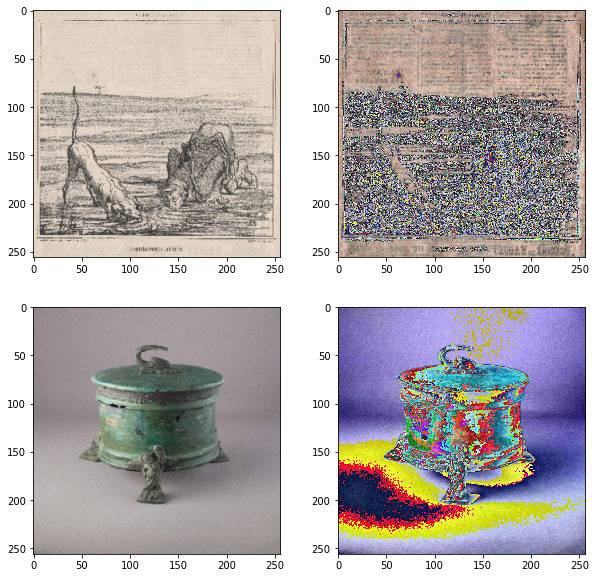

In [49]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(transforms.ToPILImage()(trainA_dataloader.dataset[0][0]).convert('RGB'))
plt.subplot(2,2,2)
plt.imshow(transforms.ToPILImage()(trainA_dataloader.dataset[0][1]).convert('RGB'))
plt.subplot(2,2,3)
plt.imshow(transforms.ToPILImage()(trainA_dataloader.dataset[29][0]).convert('RGB'))
plt.subplot(2,2,4)
plt.imshow(transforms.ToPILImage()(trainA_dataloader.dataset[29][1]).convert('RGB'))


In [50]:
#(np.array(trainC_dataloader.dataset[4][0]).shape)

In [51]:
class Ensemble(nn.Module):
    def __init__(self, modelA, modelB,input_length,output_length):
        super(Ensemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(input_length, output_length)
        
    def forward(self, xin,xin2):
        x1 = self.modelA(xin)
        x2 = self.modelB(xin2)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(F.relu(x))
        return x

densenetC_model = models.densenet161(pretrained=False)
densenetC_model.classifier= nn.Linear(in_features=2208,out_features=lable_length)
#resnetC_model = models.resnet50(pretrained=False)
resnetC_model = models.resnet18(pretrained=False)

resnetC_model.fc= nn.Linear(in_features=512, out_features=lable_length)

model = Ensemble(densenetC_model, resnetC_model,lable_length*2,lable_length)
model.cuda()


Ensemble(
  (modelA): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True,

In [52]:
#cnn = CNN(num_classes=lable_length)
# cnn = densenetC_model
# cnn.cuda()

# cnn2 = densenetT_model
# cnn2.cuda()


#print(model)

In [53]:
def train(epoch):
    for step, (x,x2,y) in enumerate(trainA_dataloader):
        data = Variable(x).cuda()   # batch x
        data2 = Variable(x2).cuda()
        target = Variable(y).cuda()   # batch y
        #print(len(np.array(target.cpu())[0]))
        #print(data.type())
        #print(target.type())
        output = model(data,data2)               # cnn output
        #loss = nn.functional.nll_loss(output, target)
        #print(len(np.array(output.cpu().detach()[0])))
        loss = loss_func(output, target.float())   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        if step==0:
            start = time.time()
            #break
            ti = 0
        elif step==100:
            ti = time.time()-start #total time = ti*(length/100)
            #print(ti)
            ti = ti*(len(trainC_dataloader)/100)
        if step % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.10f}\tTime Remain : {} '.
                     format(epoch, 
                            step * len(data), 
                            len(trainC_dataloader.dataset),
                            100.*step/len(trainC_dataloader), 
                            loss.data.item(),
                            datetime.timedelta(seconds=(ti*((int(len(trainC_dataloader)-step)/len(trainC_dataloader)))))))
        data.detach()   # batch x
        data2.detach()   # batch x
        target.detach()   # batch y
    print("Finish")

In [ ]:
for epoch in range(3):
    #if epoch==0:
    #    optimizer = torch.optim.Adam(model.parameters(), lr=0.00002/(2**epoch))
    #else:
    #    optimizer = torch.optim.SGD(model.parameters(), lr=0.00004/(2**epoch),momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00002/(2**epoch))
    #optimizer = torch.optim.ASGD(cnn.parameters(), lr=0.001)
    #optimizer = torch.optim.Adam(cnn.parameters(), lr=0.00002/(2**epoch))
    loss_func = torch.nn.MSELoss()
    #loss_func = nn.BCELoss(reduction="mean").to(device)
    #loss_func = torch.nn.BCEWithLogitsLoss()
    #loss_func = torch.nn.MultiLabelMarginLoss()
    #loss_func = torch.nn.SmoothL1Loss()
    #loss_func = FocalLoss(class_num = lable_length)
    #optimizer = torch.optim.ASGD(cnn.parameters(), lr=0.0005/(epoch+1))
    train(epoch) 

Train Epoch: 0 [0/109237 (0%)]	Loss: 0.0331985876	Time Remain : 0:00:00 
Train Epoch: 0 [3200/109237 (3%)]	Loss: 0.0035872741	Time Remain : 0:35:11.483603 


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
torch.save(model, 'net.pkl')
#model = torch.load('net.pkl')

In [ ]:
# def testFromT(model):
#     model = model.eval()
#     model = model.cpu().eval()
#     ans = []
#     for step, (x,x2, y) in enumerate(trainC_dataloader):
#         #data = Variable(x).cuda()
        
#         #his = torch.histc(data, min=0, max=5, bins=53, out=None)
#         #his = softhist(data)
#         #print(his.cpu().detach())
#         data = Variable(x)
#         data2 = Variable(x2)
#         target = np.array(y)
#         output = model(data,data2)
#         v = output.cpu().detach()
#         v = torch.sigmoid(v)
#         #avg=torch.max(v,dim=1,keepdim=True)
#         #print(len(v))
#         #for i in range(len(v)):
#             #v[i] = 1*(v[i]/avg[i])
#             #v[i] = v[i]**2
#         vp = preprocessing.minmax_scale(v, feature_range=(0,1),axis=1)
#         #vp = torch.sigmoid(v)
#         v = np.array(v)
#         vp = np.array(vp)
#         if step==0:
#             break
#         #print(v)
#         #v = preprocessing.minmax_scale(v, feature_range=(0,1),axis=1)
#         #v = min_max_scaler.fit_transform(v)
# #         v = torch.from_numpy(v)
# #         v = F.softmax(v, dim=0)
# #         v = np.array(v)
#         #v = sigmoid(v)
#         #print("==========")
#         #print(np.max(v[0]))
#         #print(np.min(v[0]))
#         #print("==========")
#     print("Finish")
#     return v,vp,target
    

In [ ]:
# v,vp,t = testFromT(model)

In [ ]:
# fig = plt.figure()
# #plt.plot(v[0][0:c_length], '-')
# plt.plot(t[0][0:c_length], '-');
# plt.plot(vp[0][0:c_length], '-');

In [ ]:
# plt.plot(t[1][0:c_length], '-');
# plt.plot(vp[1][0:c_length], '-');

In [ ]:
# plt.plot(t[2][0:c_length], '-');
# plt.plot(vp[2][0:c_length], '-');

In [ ]:
# plt.plot(t[3][0:c_length], '-');
# plt.plot(vp[3][0:c_length], '-');

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
def findPre(output,gate):
    a = ''
    output = np.array(output)
    m = np.max(output)

    for i in range(len(output)):
        #s = np.where(v[i] > 0.95, 1, 0)
        if output[i]>gate:
            #print(output[i])
            a = a + format(i)+' '
            
    #print(a)
    return a
    

In [ ]:
def test(model,dloader,threshold):
    model = model.eval().cuda()
    #lengthD = len(dloader.dataset)
    ans = []
    out = []
    for step, (x,x2, y) in enumerate(dloader):
        data = Variable(x).cuda()
        data2 = Variable(x2).cuda()
        #data = Variable(x)
        target = y
        output = model(data,data2).detach()
        
        data.cpu()   # batch x
        data2.cpu()   # batch x
        #target.cpu()   # batch y
        torch.cuda.empty_cache()
        
        v = output.cpu()
        v = torch.sigmoid(v)
        
        v = torch.sigmoid(v)
        v = np.array(v)
        v = preprocessing.minmax_scale(v, feature_range=(0,1),axis=1)
        for i in range(len(v)):
            out.append(np.where(v[i] > threshold, 1, 0))
            s = findPre(v[i],threshold)
            ans.append([target[i],s])
        if step %10 == 0:
            print('[{}/{} ({:.1f}%)]'.format(step * len(data), 
                                        len(dloader.dataset),
                                        100.*step/len(dloader)))
    print("Finish")
    return ans,out
    

In [ ]:
from sklearn.metrics import fbeta_score

def makeScore(pre,ans):
    pre = np.array(pre)
    va = fbeta_score(y_pred=pre, y_true=ans, beta=2, average="samples")
    print("Score : {:.5f}".format(va))
    return va
    

In [ ]:
def findThreshold():
    score = []
    candidates = np.arange(0, 1.0, 0.01)
    for th in candidates:
        print("Threshold : {:.2f}".format(th))
        _,pre = test(model = model,dloader = score_dataloader,threshold = th)
        #return pre
        score.append(makeScore(np.array(pre),np.array(train_a[:1000,1].tolist())))
        print("=============================")
    pm = np.array(score).argmax()
    best_th, best_score = candidates[pm], score[pm]
    return best_th, best_score

In [ ]:
bt, bs = findThreshold()
print("Best Threshold : {:.2f}".format(bt))
print("Best Score : {:.5f}".format(bs))

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
sub,_ = test(model = model,dloader = test_dataloader,threshold = bt)

In [ ]:
sub =  pd.DataFrame(sub)

In [ ]:
sub = sub.rename(index=str, columns={0: "id", 1: "attribute_ids"})

In [ ]:
sub.head

In [ ]:
sub.to_csv('submission.csv', index=False)